# Claims Prediction
This project aims to build a predictive model to determine if a building will have at least one insurance claim over the insured period.  


## Importing Relevant Libraries

In [1]:
# Core data handling & utilities
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Scikit-learn: model selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)

# Scikit-learn: preprocessing & encoding
from category_encoders import TargetEncoder
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)

# External models
import xgboost as xgb

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Scikit-learn: evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score
)

# Pipelines & utilities
from sklearn.pipeline import Pipeline
from sklearn.base import clone

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Loading and Initial Exploration of the Dataset 

In [2]:
# Initialise file path
filepath = "../data/Train_data.csv"  # Update this path as necessary

# Load dataset
try:
    df = pd.read_csv(filepath)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found. Please check file path and/or file extension.")

Dataset loaded successfully!


In [3]:
# Preview the dataset
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [4]:
# Check Data Shape
df.shape

(7160, 14)

In [5]:
# Get Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [6]:
# Statistical Summary of numeric columns
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [7]:
# Check for nulls
df.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [9]:
# Check for Duplicates
df.duplicated().sum()

np.int64(0)

#### Insight:  

After initial exploration of the data, the following was observed
- A total of 106, 7, 508 and 102 values were missing from 'Building dimension', 'Garden', 'Date_of_Occupancy', and 'Geo_Code' columns respectively.
    - 'Building Dimension' has a negligible number of missing values (less than 0.1%), unlikely to materially impact the analysis.
    - 'Garden' and 'Geo_Code' show moderate missingness, which may reflect incomplete data capture rather than random absence.
    - 'Date_of_Occupancy' has the highest number of missing values, suggesting historical records or older buildings may lack complete occupancy documentation.
- No duplicate records were observed
- Shape of dataset 7160 records and 14 columns
- Missing values will be handled within a pipeline during preprocessing stage to avoid data leakage and ensure reproducibility.

## Data Cleaning

In [14]:
df.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,2013,1.0,0,N,V,V,U,290.0,1,1960.0,0,1053,0
1,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,2014,1.0,0,N,V,V,U,595.0,1,1960.0,0,1053,0
3,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,0,1053,0
4,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [11]:
# Drop unnecessary columns
df = df.drop(['Customer Id'], axis=1)
df.columns

Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code', 'Claim'],
      dtype='object')

In [12]:
# Cleaming 'NumberOfWindows' column
df['NumberOfWindows'].value_counts()

NumberOfWindows
   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: count, dtype: int64

In [13]:
# Assuming '.' in 'NumberOfWindows' indicates 0 number of windows
df['NumberOfWindows'] = df['NumberOfWindows'].str.strip()
df['NumberOfWindows'] = df['NumberOfWindows'].str.replace('.', '0', regex=False)
df['NumberOfWindows'].value_counts()

NumberOfWindows
0       3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

### Visualise Target Variable

In [15]:
# Check target variable distribution
print("\n" + "="*80)
print("TARGET VARIABLE DISTRIBUTION")
print("="*80)
target_counts = df['Claim'].value_counts()
target_percent = 100 * df['Claim'].value_counts(normalize=True)

print("\nDistribution of Claims:")
print(f"  No Claim (0): {target_counts[0]:,} ({target_percent[0]:.2f}%)")
print(f"  Claim (1):    {target_counts[1]:,} ({target_percent[1]:.2f}%)")
print(f"\n  Imbalance Ratio: {target_counts[0]/target_counts[1]:.1f}:1")


TARGET VARIABLE DISTRIBUTION

Distribution of Claims:
  No Claim (0): 5,526 (77.18%)
  Claim (1):    1,634 (22.82%)

  Imbalance Ratio: 3.4:1


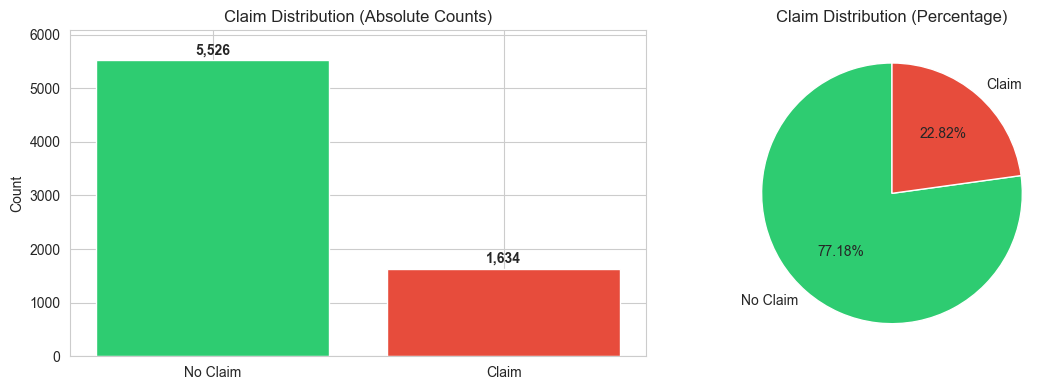

In [16]:
# Visualize target distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(['No Claim', 'Claim'], target_counts.values, color=['#2ecc71', '#e74c3c'])
ax[0].set_ylabel('Count')
ax[0].set_title('Claim Distribution (Absolute Counts)')
ax[0].set_ylim(0, max(target_counts.values) * 1.1)
for i, v in enumerate(target_counts.values):
    ax[0].text(i, v + max(target_counts.values)*0.02, f'{v:,}', ha='center', fontweight='bold')

ax[1].pie(target_counts.values, labels=['No Claim', 'Claim'], 
          autopct='%1.2f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
ax[1].set_title('Claim Distribution (Percentage)')

plt.tight_layout()
plt.show()

#### Insight: 
- The target variable exhibits an imbalance ratio of 3.4:1, indicating that buildings without insurance claims significantly outnumber those with claims.
- This level of imbalance suggests that a naïve model could achieve high accuracy by predominantly predicting the majority class (no claim), while failing to correctly identify buildings that do experience claims. As a result, accuracy alone is not a sufficient evaluation metric. Metrics such as recall, precision, F1-score, and AUC-ROC are more appropriate for assessing model performance.
- Resampling techniques (e.g., SMOTE) or class-weighted models should also be considered to improve minority class detection.

### Visualise Features

In [17]:
# numerical features
num_cols = df.select_dtypes(include=['number']).columns
if 'Claim' in num_cols:
    num_cols = num_cols.drop('Claim')  # Exclude target variable if present
print("Numerical Features:", num_cols)

Numerical Features: Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy'],
      dtype='object')


In [18]:
# Categorical features
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical Features:", cat_cols)

Categorical Features: Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object')


In [19]:
# Visualise Claims by selected categorical columns (bar if >3 categories, pie otherwise)
claims = df[df['Claim'] == 1].copy()

# Filter to existing columns and compute category counts
available_cols = [c for c in cat_cols if c in claims.columns]
missing_cols = [c for c in cat_cols if c not in claims.columns]
if missing_cols:
    print("Missing columns (skipped):", missing_cols)

bar_cols = []
pie_cols = []
for c in available_cols:
    n_cat = claims[c].value_counts(dropna=False).shape[0]
    if n_cat > 3:
        bar_cols.append(c)
    else:
        pie_cols.append(c)

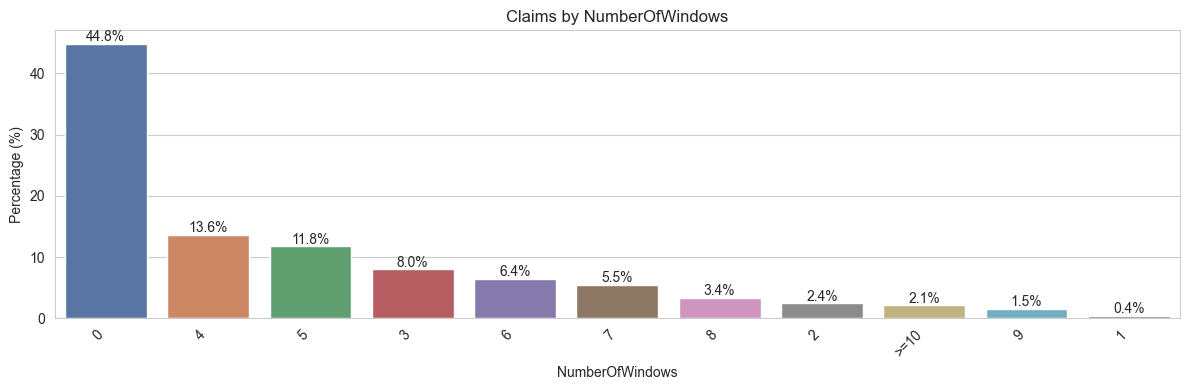

In [20]:
# Bar charts subplot (percentage-based, skip columns with >20 categories)
filtered_bar_cols = []

for col in bar_cols:
    n_unique = claims[col].nunique(dropna=False)
    if n_unique <= 50:
        filtered_bar_cols.append(col)

if filtered_bar_cols:
    n = len(filtered_bar_cols)
    ncols = 1
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(filtered_bar_cols):
        percentages = (
            claims[col]
            .value_counts(dropna=False, normalize=True)
            .mul(100)
            .sort_values(ascending=False)
        )

        sns.barplot(
            x=percentages.index.astype(str),
            y=percentages.values,
            ax=axes[i],
            palette='deep'
        )

        axes[i].set_title(f'Claims by {col}')
        axes[i].set_ylabel('Percentage (%)')
        axes[i].set_xlabel(col)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

        # Annotate bars with percentage values
        for j, v in enumerate(percentages.values):
            axes[i].text(
                j,
                v + max(percentages.values) * 0.01,
                f'{v:.1f}%',
                ha='center'
            )

    # Hide unused axes
    for k in range(i + 1, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No columns qualify for bar charts (more than 20 categories or none provided).")


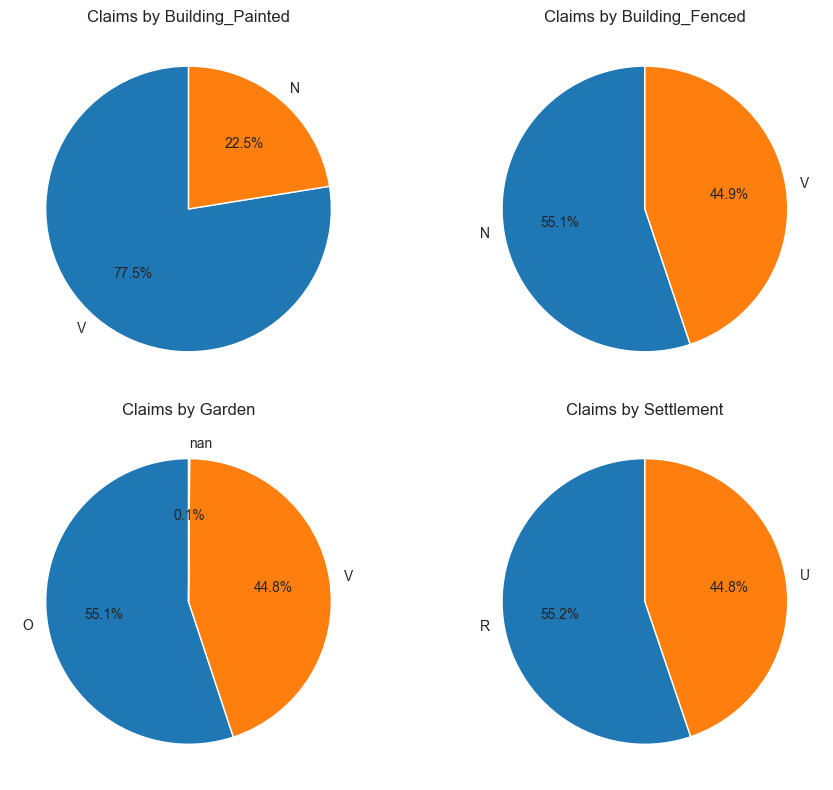

In [20]:
# Pie charts subplot (for columns with 3 or fewer categories)
if pie_cols:
    n = len(pie_cols)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()
    for i, col in enumerate(pie_cols):
        counts = claims[col].value_counts(dropna=False)
        labels = [str(l) for l in counts.index]
        my_colors = sns.color_palette('tab10', n_colors=len(labels))
        axes[i].pie(counts.values, labels=labels, autopct='%1.1f%%', startangle=90, colors=my_colors)
        axes[i].set_title(f'Claims by {col}')
    # hide unused axes
    for k in range(i+1, len(axes)):
        axes[k].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No columns require pie charts (all have more than 3 categories).")

#### Insight: 

- Approximately 44.8% of all insurance claims were associated with houses that have no windows.
- This suggests that buildings without windows may be structurally or functionally different from typical residential properties, potentially indicating:
    - Storage facilities, industrial units, or older constructions
    - Reduced ventilation or lighting, which could contribute to higher risk exposure
    - Proxy indicators of building age, usage, or maintenance quality
- This feature appears to be a strong candidate predictor and should be retained and carefully encoded during modeling.
- However, it should be noted that this observation may have been heavily influenced by the sampling, e.g the majority (over 40%) of the houses sampled had no windows, then most likely this will influence the number of claims/No claims recorded.
- Painted buildings exhibited fewer insurance claims compared to unpainted buildings. Painted buildings may suggest:
    - Better overall maintenance
    - Regular upkeep and inspections
    - Lower exposure to environmental damage (e.g., moisture, corrosion)
- This finding suggests that building maintenance indicators play an important role in claim risk and reinforces the importance of incorporating condition-related features into the predictive model.
- Claims by 'Garden', 'Settlement', and 'Building_fenced' showed and almost even distribution.
- Claims by 'Geo_code' could not be visualised due to the many unique values in the column.  

## Data Pre-processing for Predicting Claims

### Check for and Handle Outliers

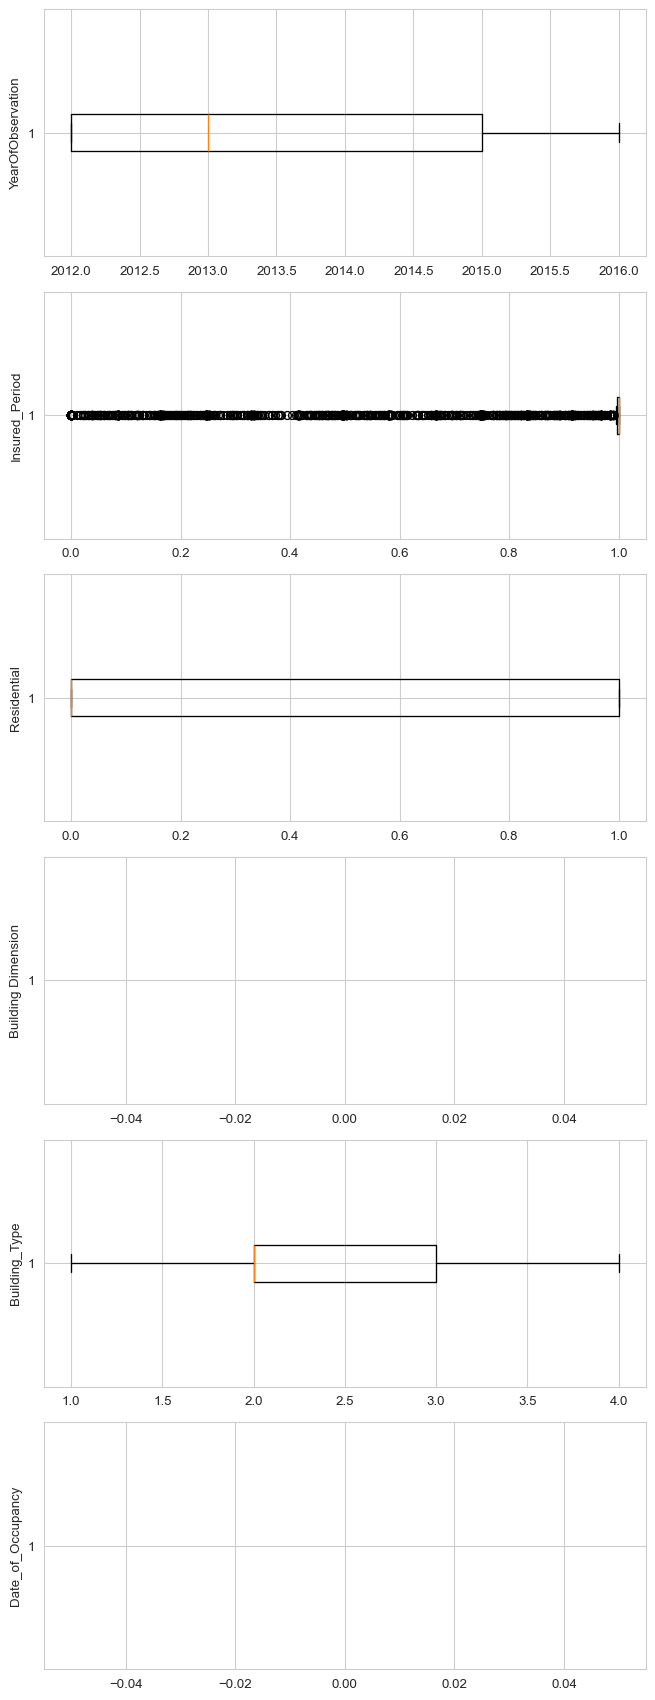

In [21]:
# Check for outliers in numerical features using box plots
fig, axs = plt.subplots(len(num_cols), 1, figsize=(7, 18), dpi=95)
for i, col in enumerate(num_cols):
    axs[i].boxplot(df[col], vert=False)
    axs[i].set_ylabel(col)
plt.tight_layout()
plt.show()

### Encode Categorical Columns using Target or OneHotEncoder

In [22]:
# Create a copy of the dataframe for encoding
df_encoded3 = df.copy()
df_encoded3.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,2013,1.0,0,N,V,V,U,290.0,1,1960.0,0,1053,0
1,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,2014,1.0,0,N,V,V,U,595.0,1,1960.0,0,1053,0
3,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,0,1053,0
4,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [23]:
# Create Binary map for yes/no fields
binary_map1 = {'N':1, 'V':0}
binary_map2 = {'V':1, 'O':0}
binary_map3 = {'U':1, 'R':0}
binary_col1 = ['Building_Painted','Building_Fenced']
binary_col2 = ['Garden']
binary_col3 = ['Settlement']
for col in binary_col1:
    if col in df_encoded3.columns:
        df_encoded3[col] = df_encoded3[col].map(binary_map1)
for col in binary_col2:
    if col in df_encoded3.columns:
        df_encoded3[col] = df_encoded3[col].map(binary_map2)
for col in binary_col3:
    if col in df_encoded3.columns:
        df_encoded3[col] = df_encoded3[col].map(binary_map3)

In [24]:
# Verify mapping
df_encoded3.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,2013,1.0,0,1,0,1.0,1,290.0,1,1960.0,0,1053,0
1,2015,1.0,0,0,1,0.0,0,490.0,1,1850.0,4,1053,0
2,2014,1.0,0,1,0,1.0,1,595.0,1,1960.0,0,1053,0
3,2013,1.0,0,0,0,1.0,1,2840.0,1,1960.0,0,1053,0
4,2014,1.0,0,0,1,0.0,0,680.0,1,1800.0,3,1053,0


In [25]:
# Checking remainging object columns
df_encoded3.select_dtypes(include=['object']).head()

,NumberOfWindows,Geo_Code
0,0,1053
1,4,1053
2,0,1053
3,0,1053
4,3,1053


In [26]:
# Split into features and target variable
X = df_encoded3.drop('Claim', axis=1).copy()
y = df_encoded3['Claim'].copy()

#### Note:
The remaining categorical columns will be encoded using target encoding. However, this will be done after train-test-split to avoid leakage. Performing encoding on X and y can permit test-set data from target to leak into training and inflate model performance. Hence, encoding will be done on teh training sets only

In [27]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (5728, 12) Test size: (1432, 12)


### Check Correlation Between Numerical Features and Target

In [28]:
# Confirm and update numerical columns
num_cols = df_encoded3.select_dtypes(include=['number']).columns.drop('Claim', errors='ignore')
print("Numerical Features after encoding:", num_cols)

Numerical Features after encoding: Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy'],
      dtype='object')


In [29]:
# Categorial features
cat_cols = df_encoded3.select_dtypes(include=['object']).columns
print("Categorical Features after encoding:", cat_cols)

Categorical Features after encoding: Index(['NumberOfWindows', 'Geo_Code'], dtype='object')


In [30]:
# create a list of numeric columns including the target column
num_cols_with_target = list(num_cols) + ['Claim']

In [31]:
# Determine correlation of features with target
num_df = df_encoded3[num_cols_with_target]
corr = num_df.corr()
corr_target = corr['Claim'].sort_values(ascending=False)

print("CORRELATION OF FEATURES WITH TARGET VARIABLE 'Claim'")
print("="*80 + "\n")
print(corr_target)

CORRELATION OF FEATURES WITH TARGET VARIABLE 'Claim'

Claim                 1.000000
Building Dimension    0.297089
Building_Type         0.112168
Insured_Period        0.088715
Residential           0.063509
Building_Fenced       0.051657
Date_of_Occupancy     0.019170
YearOfObservation    -0.016367
Building_Painted     -0.029857
Settlement           -0.052019
Garden               -0.052093
Name: Claim, dtype: float64


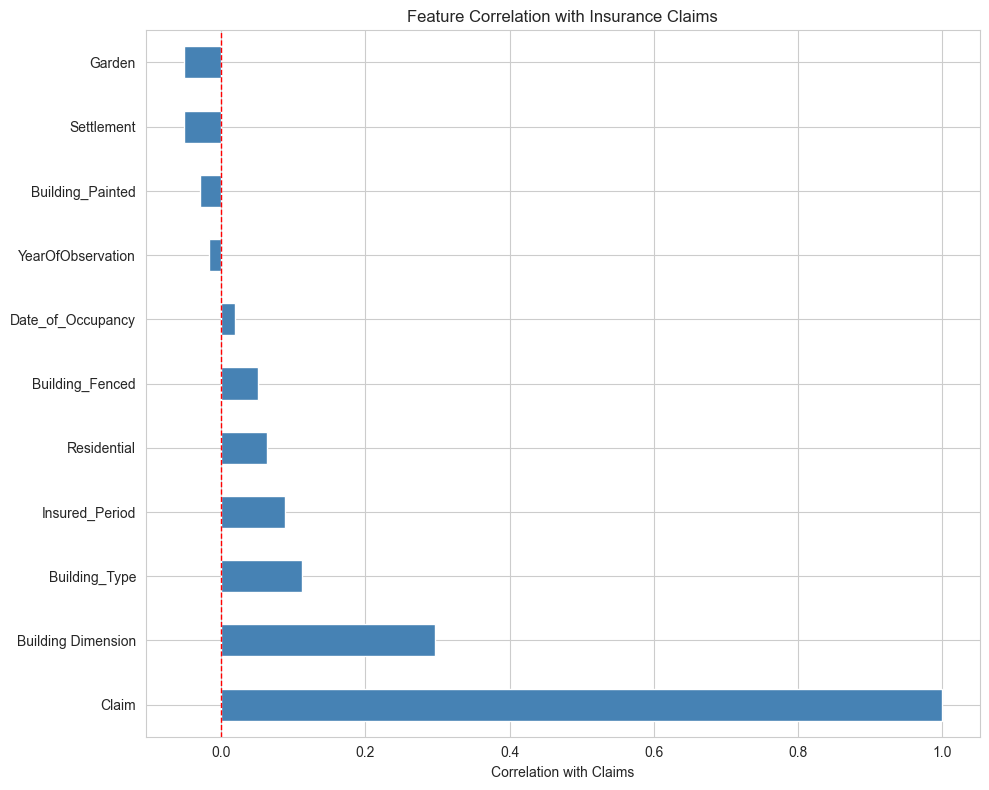

In [32]:
# Visualize feature correlation with Target
plt.figure(figsize=(10, 8))
corr_target.plot(kind='barh', color='steelblue')
plt.xlabel('Correlation with Claims')
plt.title('Feature Correlation with Insurance Claims')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

#### Insight:

- All correlations are below 0.3, indicating no single variable explains claim occurrence on its own.
- Building dimension shows the strongest linear relationship with insurance claims among all evaluated features.
- Building type demonstrates a weak but meaningful positive correlation with claim occurrence.
- The insured period shows a slight positive correlation, indicating that some insurance coverage durations have more likelihood to attract claims than others.

### Preprocess features in Pipeline to scale and handle any missing values 

In [33]:
# Create a list of numerical and categorical columns
num_cols_list = list(num_cols)
cat_cols_list = list(cat_cols)

In [34]:
# Numeric preprocessing
num_t = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [35]:
# Categorical preprocessing
cat_t = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("targenc", TargetEncoder(handle_unknown="value", handle_missing="value"))
])

In [36]:
# Full preprocessor
preproc = ColumnTransformer([
    ("num", num_t, num_cols_list),
    ("cat", cat_t, cat_cols_list)
])

## Build and Compare Models

In [40]:
# Keep unscaled copies
X_train_unscaled = X_train.copy() if hasattr(X_train, "copy") else pd.DataFrame(X_train)
X_test_unscaled  = X_test.copy()  if hasattr(X_test,  "copy") else pd.DataFrame(X_test)

In [41]:
# Define Helper Function for Model Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, use_smote=False, cv=None):
    """
    Trains and evaluates a classification model.
    Optionally applies SMOTE for resampling imbalanced data.

    Parameters:
        model: scikit-learn model object
        X_train, y_train, X_test, y_test: training and testing sets
        use_smote: bool, whether to apply SMOTE (for KNN in this example)

    Returns:
        dict: containing model name and performance metrics
    """
     # Apply SMOTE only on training set if needed
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Fit the pipeline
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)
    
    # Evaluate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Optional cross-validated recall on training set
    if cv:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
        metrics['CV Recall'] = cv_scores.mean()
    
    return metrics

In [42]:
# Define Models to Compare
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', 
                        max_iter=1000, 
                        random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced',
                        max_depth=5,
                        min_samples_split=50,
                        min_samples_leaf=20,
                        random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced',
                        n_estimators=100,
                        max_depth=10,
                        min_samples_split=50,
                        min_samples_leaf=20,
                        random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100,
                        learning_rate=0.1,
                        max_depth=5,
                        min_samples_split=50,
                        min_samples_leaf=20,
                        random_state=42),
    'KNN (SMOTE)': KNeighborsClassifier(n_neighbors=5),
    'XGB Classifier': xgb.XGBClassifier(random_state=42, 
                        use_label_encoder=False, 
                        eval_metric='logloss'),
    'SVC' : SVC(class_weight='balanced',
                        probability=True)
}

In [43]:
# Model evaluation
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preproc', preproc),
        ('classifier', model)
    ])
    
    use_smote = True if name == "KNN" else False
    metrics = evaluate_model(
        pipeline,
        X_train,
        y_train,
        X_test,
        y_test,
        use_smote=use_smote,
        cv=5  # 5-fold CV recall
    )
    
    results[name] = metrics


In [44]:
# Print evaluation results as a DataFrame
results_df = pd.DataFrame(results).T  # transpose so models are rows
results_df = results_df[['Accuracy', 'Recall', 'Precision', 'F1-Score', 
                         'AUC-ROC', 'CV Recall', 'Confusion Matrix']]
print("\n" + "=" * 80)
print("COMPARISON SUMMARY")
print("=" * 80)
results_df


COMPARISON SUMMARY


,Accuracy,Recall,Precision,F1-Score,AUC-ROC,CV Recall,Confusion Matrix
Logistic Regression,0.671089,0.470948,0.340708,0.395379,0.656441,0.537855,"[[807, 298], [173, 154]]"
Decision Tree,0.577514,0.593272,0.291291,0.390735,0.617581,0.54326,"[[633, 472], [133, 194]]"
Random Forest,0.657821,0.498471,0.333333,0.39951,0.642962,0.540201,"[[779, 326], [164, 163]]"
Gradient Boosting,0.761872,0.232416,0.457831,0.308316,0.637057,0.273941,"[[1015, 90], [251, 76]]"
KNN (SMOTE),0.77095,0.281346,0.497297,0.359375,0.648297,0.24636,"[[1012, 93], [235, 92]]"
XGB Classifier,0.744413,0.253823,0.404878,0.31203,0.63357,0.283888,"[[983, 122], [244, 83]]"
SVC,0.694134,0.519878,0.37694,0.437018,0.686609,0.569232,"[[824, 281], [157, 170]]"


#### Insight:
- The Decision Tree model demonstrates the strongest ability to correctly identify claim cases (Test Recall: 0.59), making it the most effective model for minimizing false negatives. 
- This is particularly important in an insurance context, where failing to identify a high-risk building can result in unexpected financial exposure.
- However, the slight drop in cross-validated recall (0.54) suggests some degree of overfitting and sensitivity to the specific train–test split.
- This indicates that while the Decision Tree performs well, it may benefit from pruning or hyperparameter tuning to improve generalization.  

- The SVC model also shows robust and stable recall performance (Test Recall: 0.52), with cross-validation results (0.57) slightly outperforming the single test split. 
- This consistency suggests better generalisation across different data subsets, and lower variance compared to the Decision Tree
- Although its test recall is marginally lower than that of the Decision Tree, the SVC’s stronger cross-validated recall highlights it as a reliable alternative, particularly in production environments.

## Hyperparameter Tuning with GridSearchCV

### Tuning SVC Model

In [45]:
# Pipeline with SVC
svc_pipeline = Pipeline([
    ("preproc", preproc),
    ("svc", SVC())
])

In [ ]:
# Hyperparameter Tuning for SVC Model
param_grid_svc = {'svc__C': [0.1, 1, 10, 100, 1000], 
			    'svc__kernel': ['linear', 'rbf'],
                'svc__gamma': ['scale', 'auto']}

svc_grid = GridSearchCV(
    svc_pipeline,
    param_grid_svc,
    cv=5,
    scoring='recall'  # or any other metric
)

svc_grid.fit(X_train, y_train)


In [ ]:
# Print best parameters from GridSearchCV
print("Best Parameters from GridSearchCV for SVC:")
print(svc_grid.best_params_)
print("\nBest Estimators from GridSearchCV for SVC:")
print(svc_grid.best_estimator_)

In [ ]:
# Make predictions with the best estimator
svc_best_model = svc_grid.best_estimator_
svc_grid_pred = svc_best_model.predict(X_test) 

In [ ]:
# Evaluate the tuned SVC model
svc_eval_results = evaluate_model(clone(svc_best_model), X_train, y_train, X_test, y_test)

In [ ]:
# Display evaluation results for SVC
print("\n" + "=" * 80)
print("Evaluation Results for Tuned SVC Model:")
print("=" * 80)
svc_eval_results
